# Business Question

The New York Times is reevaluating the comment moderation on its web content, in hopes of stimulating reader engagement, deepening the quality of user feedback, and identifying potentially problematic comments more quickly. They would like to use the existing recommendation tool to develop a machine learning model that will predict which comments will be most popular and which comments will be most likely to generate further engagement. The end goal will be to sort comments according to this prediction (as a third option available to users in addition to presenting comments ranked in response to recommendations or chronologically). Additionally, they would like to identify comments that are most likely to be flagged as abuse to bring these comments to the attention of moderators more quickly. 

### Data Acquisition
The data used for this project represents articles and comments on The New York Times website in April 2017. I downloaded the dataset from Kaggle [at this address](https://www.kaggle.com/aashita/nyt-comments). The data was originally collected using the New York Times API. The process for this collection is well-documented on the Kaggle page. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist

#hate speech library
from hatesonar import Sonar

#toggle variable to print previews, 'sanity checks'
print_detail = True

## Preprocessing

In [2]:
# DELETE ME if you end up wanting to expand and add more data to the dataset, you can combine the datasets before this cell 
# and name them art/comm and then pick up at this point.

# article_paths = ['data/ArticlesApril2017.csv',
#                  'data/ArticlesApril2018.csv',
#                  'data/ArticlesJan2017.csv',
#                  'data/ArticlesJan2018.csv']

# comment_paths = ['data/CommentsApril2017.csv',
#                  'data/CommentsApril2018.csv',
#                  'data/CommentsJan2017.csv',
#                  'data/CommentsJan2018.csv']

# read in datasets of articles
# art = pd.read_csv(article_paths[0])
# for each in article_paths[1:]:
#     print('appending ' + each)
#     temp = pd.read_csv(each)
#     art = pd.concat([art, temp])
#     print('df shape ' + str(art.shape))
        
# read in dataset of comments
# comm = pd.read_csv(comment_paths[0])
# for each in comment_paths[1:]:
#     print('appending ' + each)
#     temp = pd.read_csv(each)
#     comm = pd.concat([comm, temp])
#     print('df shape ' + str(comm.shape))


art = pd.read_csv('data/ArticlesApril2018.csv')

comm = pd.read_csv('data/CommentsApril2018.csv')
    
if print_detail:
    # preview
    display(art.info())
    display(comm.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   articleID         1324 non-null   object
 1   articleWordCount  1324 non-null   int64 
 2   byline            1324 non-null   object
 3   documentType      1324 non-null   object
 4   headline          1324 non-null   object
 5   keywords          1324 non-null   object
 6   multimedia        1324 non-null   int64 
 7   newDesk           1324 non-null   object
 8   printPage         1324 non-null   int64 
 9   pubDate           1324 non-null   object
 10  sectionName       1324 non-null   object
 11  snippet           1324 non-null   object
 12  source            1324 non-null   object
 13  typeOfMaterial    1324 non-null   object
 14  webURL            1324 non-null   object
dtypes: int64(3), object(12)
memory usage: 155.3+ KB


C:\Users\carly\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264924 entries, 0 to 264923
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   approveDate            264924 non-null  int64  
 1   articleID              264924 non-null  object 
 2   articleWordCount       264924 non-null  float64
 3   commentBody            264924 non-null  object 
 4   commentID              264924 non-null  float64
 5   commentSequence        264924 non-null  float64
 6   commentTitle           264911 non-null  object 
 7   commentType            264924 non-null  object 
 8   createDate             264924 non-null  int64  
 9   depth                  264924 non-null  float64
 10  editorsSelection       264924 non-null  bool   
 11  inReplyTo              264924 non-null  float64
 12  newDesk                264924 non-null  object 
 13  parentID               264924 non-null  float64
 14  parentUserDisplayName  83875 non-nul

None

In [3]:
if print_detail:
    #preview
    display(art.head())
    display(comm.head())

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,What’s it like to eat at the second incarnatio...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
3,5adf40d2068401528a2aa619,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...
4,5adf3d64068401528a2aa60f,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Toronto’s Ri...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...


,approveDate,articleID,articleWordCount,commentBody,commentID,commentSequence,commentTitle,commentType,createDate,depth,...,status,timespeople,trusted,typeOfMaterial,updateDate,userDisplayName,userID,userLocation,userTitle,userURL
0,1524594282,5adf6684068401528a2aa69b,781.0,How could the league possibly refuse this offe...,26853969.0,26853969.0,<br/>,comment,1524594011,1.0,...,approved,1,0,News,1524594282,Christopher Rillo,46566740.0,San Francisco,NaN,NaN
1,1524594252,5adf6684068401528a2aa69b,781.0,"So then the execs can be like ""yeah...we will ...",26853699.0,26853699.0,<br/>,comment,1524593146,1.0,...,approved,1,0,News,1524594252,Matt Brand,64324866.0,"Williamsburg, Brooklyn",NaN,NaN
2,1524594250,5adf6684068401528a2aa69b,781.0,I would not want to play chess against these c...,26853677.0,26853677.0,<br/>,comment,1524593032,1.0,...,approved,1,0,News,1524594250,Joseph,78105093.0,"Fayetteville, AR",NaN,NaN
3,1524593431,5adf6684068401528a2aa69b,781.0,Could the cheerleaders join the Actors' Equity...,26853784.0,26853784.0,<br/>,comment,1524593426,1.0,...,approved,0,0,News,1524593431,Stephen,81939618.0,"Phoenix, AZ",NaN,NaN
4,1524595048,5adf653f068401528a2aa697,656.0,Seeking conclusions which support preconceived...,26854236.0,26854236.0,<br/>,comment,1524595043,1.0,...,approved,1,0,News,1524595048,Paul Zorsky,58642997.0,Texas,NaN,NaN


In [4]:
print('Article columns: ')
display(art.columns)
print('Comments columns: ')
display(comm.columns)

Article columns: 


Index(['articleID', 'articleWordCount', 'byline', 'documentType', 'headline',
       'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')

Comments columns: 


Index(['approveDate', 'articleID', 'articleWordCount', 'commentBody',
       'commentID', 'commentSequence', 'commentTitle', 'commentType',
       'createDate', 'depth', 'editorsSelection', 'inReplyTo', 'newDesk',
       'parentID', 'parentUserDisplayName', 'permID', 'picURL', 'printPage',
       'recommendations', 'recommendedFlag', 'replyCount', 'reportAbuseFlag',
       'sectionName', 'sharing', 'status', 'timespeople', 'trusted',
       'typeOfMaterial', 'updateDate', 'userDisplayName', 'userID',
       'userLocation', 'userTitle', 'userURL'],
      dtype='object')

In [5]:
#combine the article and comment dataframes using articleID as an index
df = pd.merge(comm, art, on='articleID')

if print_detail:
    df.head()

In [6]:
df.columns

Index(['approveDate', 'articleID', 'articleWordCount_x', 'commentBody',
       'commentID', 'commentSequence', 'commentTitle', 'commentType',
       'createDate', 'depth', 'editorsSelection', 'inReplyTo', 'newDesk_x',
       'parentID', 'parentUserDisplayName', 'permID', 'picURL', 'printPage_x',
       'recommendations', 'recommendedFlag', 'replyCount', 'reportAbuseFlag',
       'sectionName_x', 'sharing', 'status', 'timespeople', 'trusted',
       'typeOfMaterial_x', 'updateDate', 'userDisplayName', 'userID',
       'userLocation', 'userTitle', 'userURL', 'articleWordCount_y', 'byline',
       'documentType', 'headline', 'keywords', 'multimedia', 'newDesk_y',
       'printPage_y', 'pubDate', 'sectionName_y', 'snippet', 'source',
       'typeOfMaterial_y', 'webURL'],
      dtype='object')

Before I start the Exploratory Data Analysis (EDA), I want to eliminate some of the columns that are duplicates, or contain information that I know won't be helpful (such as URLs). Some of these columns I'm still unsure about. 

In [7]:
def reverse_drop(df, keep_list):
    '''pass in a dataframe and a list of the columns to keep. Will ID all columns NOT in list
    and drop them, returning the resulting dataframe'''
    
    
    to_drop = [item for item in list(df.columns) if item not in keep_list]

    # if print_detail:
    #     print(to_drop)

    return df.drop(columns=to_drop)


In [8]:
keep = ['commentBody', 'commentID', 'commentType', 
        'editorsSelection','recommendations', 'replyCount', 'articleID',
        'timespeople', 'trusted','sectionName_x', 'depth', 'inReplyTo',
        'newDesk_x', 'articleWordCount_x', 'typeOfMaterial_x' , 'pubDate',
        'documentType', 'headline']

df = reverse_drop(df, keep)

if print_detail:
    print(df.columns)

Index(['articleID', 'articleWordCount_x', 'commentBody', 'commentID',
       'commentType', 'depth', 'editorsSelection', 'inReplyTo', 'newDesk_x',
       'recommendations', 'replyCount', 'sectionName_x', 'timespeople',
       'trusted', 'typeOfMaterial_x', 'documentType', 'headline', 'pubDate'],
      dtype='object')


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257661 entries, 0 to 257660
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   articleID           257661 non-null  object 
 1   articleWordCount_x  257661 non-null  float64
 2   commentBody         257661 non-null  object 
 3   commentID           257661 non-null  float64
 4   commentType         257661 non-null  object 
 5   depth               257661 non-null  float64
 6   editorsSelection    257661 non-null  bool   
 7   inReplyTo           257661 non-null  float64
 8   newDesk_x           257661 non-null  object 
 9   recommendations     257661 non-null  int64  
 10  replyCount          257661 non-null  int64  
 11  sectionName_x       257661 non-null  object 
 12  timespeople         257661 non-null  int64  
 13  trusted             257661 non-null  int64  
 14  typeOfMaterial_x    257661 non-null  object 
 15  documentType        257661 non-nul

## EDA part 1

### Initial Article Analysis/Feature Engineering

In [10]:
def quick_look(frame, col, range = None, bins = 10):
    '''displays the name, describe(), and histogram for the
        specified column'''
    print(col + ' description: ')
    display(frame[col].describe())
    display(frame[col].value_counts())
    
    if frame[col].nunique == 2:
        print('Boolean variable; no histogram created')
    
    else:
    
        plt.hist(frame[col],
                      range = range,
                      bins = bins)

        plt.title(col + ' Histogram')
        plt.show()

how many articles

In [11]:
print('Number of Articles: ')
print(df['articleID'].nunique())

Number of Articles: 
1324


section breakdown

One of the more interesting and useful ways that the data segments itself is by section. There are several variables (sectionName, newDesk, typeOfMaterial) that might end up being best for sorting the data, so I want to take a look at each of them to see which one is most helpful.

In [12]:
# the saddest little helper function
def print_categories(column):
    '''the function will print the name of a given column as well as all of the categories in that column'''
    print(column)
    display(df[column].unique())

#create a list of potential section variables
potential_ys = ['sectionName_x', 'newDesk_x', 'typeOfMaterial_x']

# print categories for each of the potential section variables
for each in potential_ys:
    print_categories(each)

sectionName_x


array(['Pro Football', 'Unknown', 'Europe', 'Canada', 'Politics',
       'Book Review', 'Eat', 'DealBook', 'Asia Pacific',
       'Wine, Beer & Cocktails', 'Family', 'Hockey', 'Africa',
       'Television', 'Economy', 'Middle East', 'Tennis', 'Sunday Review',
       'Live', 'The Daily', 'Move', 'Cycling', 'Americas', 'Australia',
       'Weddings', 'Art & Design', 'Lesson Plans', 'Personal Tech',
       'Music', 'Mind', 'Pro Basketball', 'Learning', 'Media', 'Golf',
       'College Basketball', 'Soccer'], dtype=object)

newDesk_x


array(['Sports', 'Climate', 'Dining', 'Washington', 'Foreign', 'NYTNow',
       'Express', 'Insider', 'Learning', 'Magazine', 'Metro',
       'RealEstate', 'Business', 'Politics', 'National',
       'SpecialSections', 'BookReview', 'Well', 'Games', 'Culture',
       'Editorial', 'OpEd', 'Arts&Leisure', 'Science', 'Travel', 'Upshot',
       'Metropolitan', 'Investigative', 'NewsDesk', 'Weekend',
       'SundayBusiness', 'Styles', 'Photo', 'Society', 'Obits',
       'Smarter Living', 'Podcasts', 'TStyle', 'Summary'], dtype=object)

typeOfMaterial_x


array(['News', 'briefing', 'Review', 'Editorial', 'Op-Ed',
       'News Analysis', 'Question', 'Obituary (Obit)'], dtype=object)

In [13]:
df_sections = df.groupby(by='newDesk_x').count()

display(df_sections)
df_sections.sort_values('commentBody', ascending=False)

,articleID,articleWordCount_x,commentBody,commentID,commentType,depth,editorsSelection,inReplyTo,recommendations,replyCount,sectionName_x,timespeople,trusted,typeOfMaterial_x,documentType,headline,pubDate
newDesk_x,,,,,,,,,,,,,,,,,
Arts&Leisure,497,497,497,497,497,497,497,497,497,497,497,497,497,497,497,497,497
BookReview,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036
Business,20697,20697,20697,20697,20697,20697,20697,20697,20697,20697,20697,20697,20697,20697,20697,20697,20697
Climate,3885,3885,3885,3885,3885,3885,3885,3885,3885,3885,3885,3885,3885,3885,3885,3885,3885
Culture,4803,4803,4803,4803,4803,4803,4803,4803,4803,4803,4803,4803,4803,4803,4803,4803,4803
Dining,1705,1705,1705,1705,1705,1705,1705,1705,1705,1705,1705,1705,1705,1705,1705,1705,1705
Editorial,10774,10774,10774,10774,10774,10774,10774,10774,10774,10774,10774,10774,10774,10774,10774,10774,10774
Express,2595,2595,2595,2595,2595,2595,2595,2595,2595,2595,2595,2595,2595,2595,2595,2595,2595
Foreign,14655,14655,14655,14655,14655,14655,14655,14655,14655,14655,14655,14655,14655,14655,14655,14655,14655


,articleID,articleWordCount_x,commentBody,commentID,commentType,depth,editorsSelection,inReplyTo,recommendations,replyCount,sectionName_x,timespeople,trusted,typeOfMaterial_x,documentType,headline,pubDate
newDesk_x,,,,,,,,,,,,,,,,,
OpEd,80574,80574,80574,80574,80574,80574,80574,80574,80574,80574,80574,80574,80574,80574,80574,80574,80574
Washington,51576,51576,51576,51576,51576,51576,51576,51576,51576,51576,51576,51576,51576,51576,51576,51576,51576
Business,20697,20697,20697,20697,20697,20697,20697,20697,20697,20697,20697,20697,20697,20697,20697,20697,20697
Foreign,14655,14655,14655,14655,14655,14655,14655,14655,14655,14655,14655,14655,14655,14655,14655,14655,14655
National,12293,12293,12293,12293,12293,12293,12293,12293,12293,12293,12293,12293,12293,12293,12293,12293,12293
Editorial,10774,10774,10774,10774,10774,10774,10774,10774,10774,10774,10774,10774,10774,10774,10774,10774,10774
Politics,7582,7582,7582,7582,7582,7582,7582,7582,7582,7582,7582,7582,7582,7582,7582,7582,7582
Well,6126,6126,6126,6126,6126,6126,6126,6126,6126,6126,6126,6126,6126,6126,6126,6126,6126
Magazine,5552,5552,5552,5552,5552,5552,5552,5552,5552,5552,5552,5552,5552,5552,5552,5552,5552


how many comments/article

commentID description: 


count    1324.000000
mean      194.608006
std       327.383266
min         1.000000
25%        16.000000
50%        67.000000
75%       215.000000
max      3823.000000
Name: commentID, dtype: float64

1       41
4       31
5       29
3       28
2       26
        ..
2245     1
196      1
483      1
486      1
2296     1
Name: commentID, Length: 467, dtype: int64

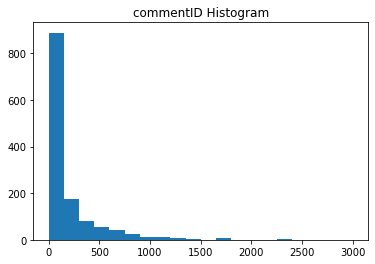

In [14]:
article_group = df.groupby(by='articleID').count()

quick_look(article_group, 'commentID', (0,3000), 20)


create a new column that lists the total number of comments for the article

In [15]:
df['article_comment_total'] = df['articleID'].apply(lambda x: article_group['commentID'][x])

In [16]:
article_sections =df.groupby(['newDesk_x']).mean()

article_sections['article_comment_total']

#quick_look(article_sections, 'commentID', (0,3000), 20)


newDesk_x
Arts&Leisure         45.241449
BookReview          567.117761
Business            942.381843
Climate             659.906564
Culture             447.141578
Dining              173.668622
Editorial           721.511045
Express             727.716763
Foreign             376.855067
Games               115.269935
Insider              94.669173
Investigative       764.772205
Learning            442.745052
Magazine            512.066643
Metro               278.060062
Metropolitan        203.882022
NYTNow               16.055556
National            430.648418
NewsDesk           1014.400980
Obits               421.820823
OpEd                692.985281
Photo                13.967742
Podcasts              2.142857
Politics            950.525719
RealEstate           79.224051
Science             411.371908
Smarter Living       53.036364
Society              99.000000
SpecialSections     119.144000
Sports              420.493827
Styles              239.896989
Summary               6.00000

comment length

In [17]:
article_group_sum = df.groupby(by='articleID').sum()
article_group_sum

,articleWordCount_x,commentID,depth,editorsSelection,inReplyTo,recommendations,replyCount,timespeople,trusted,article_comment_total
articleID,,,,,,,,,,
5abcf77c068401528a29efbe,4554.0,1.593830e+08,7.0,0,2.658183e+07,6,1,5,0,36
5abcfffe068401528a29f021,3501.0,2.388898e+08,10.0,0,2.653595e+07,47,1,8,0,81
5abd03ab068401528a29f062,202095.0,3.582519e+09,199.0,1,1.645151e+09,1029,77,130,7,18225
5abd080c068401528a29f099,108875.0,1.778602e+09,87.0,0,5.309005e+08,640,21,60,1,4489
5abd0a47068401528a29f0b3,131355.0,2.786208e+09,143.0,0,1.008292e+09,969,39,101,4,11025
...,...,...,...,...,...,...,...,...,...,...
5ae82c95068401528a2ab96b,7301.0,1.885735e+08,7.0,0,0.000000e+00,23,0,6,0,49
5ae82c97068401528a2ab96c,3140.0,1.077396e+08,4.0,0,0.000000e+00,0,0,4,0,16
5ae82c9d068401528a2ab96d,1318.0,5.386605e+07,2.0,0,0.000000e+00,8,0,2,0,4


replyCount: replies to that comment
article_reply_total: total number of replies

In [18]:
df['article_rec_total'] = df['articleID'].apply(lambda x: article_group_sum['recommendations'][x])
df['article_reply_total'] = df['articleID'].apply(lambda x: article_group_sum['replyCount'][x])

In [19]:
df.columns

Index(['articleID', 'articleWordCount_x', 'commentBody', 'commentID',
       'commentType', 'depth', 'editorsSelection', 'inReplyTo', 'newDesk_x',
       'recommendations', 'replyCount', 'sectionName_x', 'timespeople',
       'trusted', 'typeOfMaterial_x', 'documentType', 'headline', 'pubDate',
       'article_comment_total', 'article_rec_total', 'article_reply_total'],
      dtype='object')

In [20]:
def flag_highest_adjusted(group_col, new_col, continuous_col):

    #create a list of all sections
    sections = list(df['newDesk_x'].unique())

    #create an empty dictionary
    percentiles = {}

    #populate with section names and the 90th percentile value of total comments
    for i in sections:
        percentiles[i] = df.loc[df['newDesk_x'] == i].groupby(group_col).mean()[continuous_col].quantile(0.9)

    # function to label articles as highly commented if they fall in the 90th percentile of comments for their section
    def flag_upper_percentile(section, value):
        '''accepts a section title and total number of comments for a given article as parameters
        uses the above dictionary to determine whether the given article's total comment count is
        in the 90th percentile
        if so, flags as true''' 
        if value > percentiles[section]:
            return True
        else:
            return False

    df[new_col] = df.apply(lambda x: flag_upper_percentile(x['newDesk_x'], x[continuous_col]), axis=1)

In [21]:
flag_highest_adjusted('articleID', 'highly_commented', 'article_comment_total')
flag_highest_adjusted('articleID', 'high_total_recommendations', 'article_rec_total')
flag_highest_adjusted('articleID', 'high_total_reply', 'article_reply_total')

### High-Engagement Articles

### Comment Analysis

,commentLength,commentBody
0,8,How could the league possibly refuse this offe...
1,21,"So then the execs can be like ""yeah...we will ..."
2,12,I would not want to play chess against these c...
3,37,Could the cheerleaders join the Actors' Equity...
4,95,We all know that if the cheerleaders were all ...
...,...,...
257656,60,This year was uniquely unoriginal - the four n...
257657,5,"Come From Away, last year..."
257658,32,I love this quiet little musical. Exquisite pe...
257659,43,We saw it about 10 days ago. Agree with your ...


commentLength description: 


count    257661.000000
mean         66.330349
std          59.136408
min           1.000000
25%          23.000000
50%          47.000000
75%          90.000000
max         305.000000
Name: commentLength, dtype: float64

13     3458
12     3444
14     3441
20     3429
15     3417
       ... 
292       1
305       1
303       1
296       1
300       1
Name: commentLength, Length: 298, dtype: int64

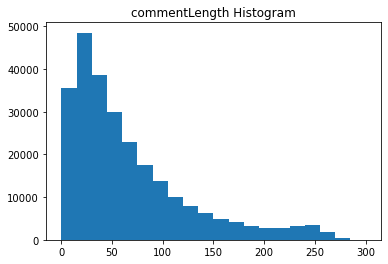

In [22]:
df['commentLength'] = df['commentBody'].apply(lambda x: len(x.split()))

if print_detail:
    display(df[['commentLength', 'commentBody']])

quick_look(df, 'commentLength', (0, 300), 20)

recommendations description: 


count    257661.000000
mean         18.622865
std          90.600530
min           0.000000
25%           1.000000
50%           4.000000
75%          12.000000
max        8713.000000
Name: recommendations, dtype: float64

0       41446
1       31945
2       25015
3       19860
4       16192
        ...  
425         1
553         1
809         1
937         1
1151        1
Name: recommendations, Length: 1213, dtype: int64

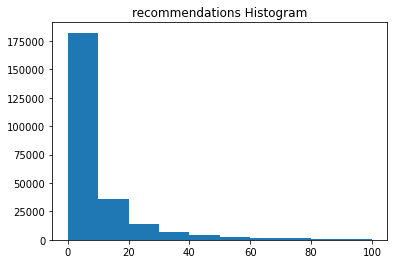

In [23]:
quick_look(df, 'recommendations', (0, 100))

In [24]:
#feature engineer recommendations into highly recommended
flag_highest_adjusted('commentID', 'highly_recommended', 'recommendations')
df['recommended'] = df['recommendations'].apply(lambda x: True if x > 0 else False)
if print_detail:
    display(df['recommended'].value_counts())
    display(df['highly_recommended'].value_counts())

True     216215
False     41446
Name: recommended, dtype: int64

False    232315
True      25346
Name: highly_recommended, dtype: int64

replyCount description: 


count    257661.000000
mean          0.419283
std           2.365486
min        -114.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         668.000000
Name: replyCount, dtype: float64

0      208052
1       29039
2        9790
3        4333
4        2255
        ...  
39          1
53          1
530         1
41          1
120         1
Name: replyCount, Length: 72, dtype: int64

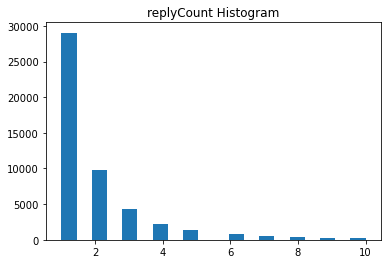

In [25]:
#reply count
quick_look(df, 'replyCount', (1, 10), 20)

In [26]:
#feature engineering reply count into categorical

df['replied_to'] = df['replyCount'].apply(lambda x: True if x > 0 else False)
df['highly_replied_to'] = df['replyCount'].apply(lambda x: True if x > 5 else False)

if print_detail:
    display(df['replied_to'].value_counts())
    display(df['highly_replied_to'].value_counts())

False    208053
True      49608
Name: replied_to, dtype: int64

False    254798
True       2863
Name: highly_replied_to, dtype: int64

In [27]:
df.loc[df['replyCount'] < 0]

,articleID,articleWordCount_x,commentBody,commentID,commentType,depth,editorsSelection,inReplyTo,newDesk_x,recommendations,...,article_rec_total,article_reply_total,highly_commented,high_total_recommendations,high_total_reply,commentLength,highly_recommended,recommended,replied_to,highly_replied_to
29529,5ada0944068401528a2a9d2f,2021.0,Hillary Clinton suffered what has to be consid...,26811388.0,comment,1.0,True,0.0,OpEd,858,...,46087,1140,True,True,True,227,True,True,False,False


depth description: 


count    257661.000000
mean          1.337707
std           0.517679
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           5.000000
Name: depth, dtype: float64

1.0    176190
2.0     76079
3.0      5258
4.0       117
5.0        17
Name: depth, dtype: int64

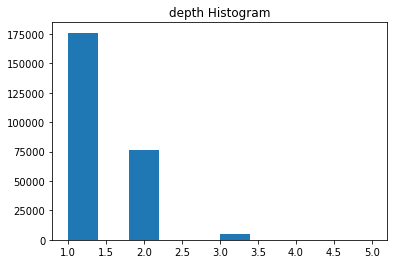

In [28]:
#depth
quick_look(df, 'depth', (1, 5))

editorsSelection description: 


count     257661
unique         2
top        False
freq      253674
Name: editorsSelection, dtype: object

False    253674
True       3987
Name: editorsSelection, dtype: int64

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


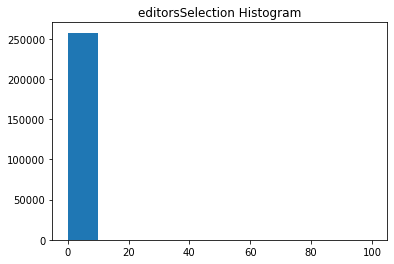

In [29]:
#editor selected
quick_look(df, 'editorsSelection', (0, 100))

timespeople description: 


count    257661.000000
mean          0.917644
std           0.274907
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: timespeople, dtype: float64

1    236441
0     21220
Name: timespeople, dtype: int64

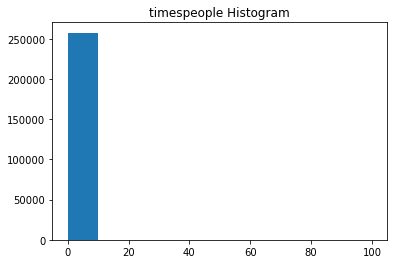

In [30]:
#timespeople
quick_look(df, 'timespeople', (0, 100))

trusted description: 


count    257661.000000
mean          0.033109
std           0.178923
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: trusted, dtype: float64

0    249130
1      8531
Name: trusted, dtype: int64

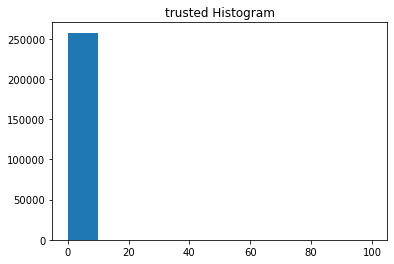

In [31]:
#trusted
quick_look(df, 'trusted', (0, 100))

### Feature Engineering Abuse Flag

In [32]:
# using this function to detect if we have any abusive comments

def get_top_hs_class(sonar_obj, comment):
    '''accepts a HateSonar Sonar object and a string comment (unprocessed) and returns the class with 
    the highest confidence score.
    Class options are: hate speech, offensive language, neither'''
    results = sonar_obj.ping(text=comment)

    # hs_conf = results['classes']['class_name' == 'hate_speech']['confidence']
    # off_conf = results['classes']['class_name' == 'offensive_language']['confidence']
    # none_conf = results['classes']['class_name' == 'neither']['confidence']

    return results['top_class']

In [33]:
sonar = Sonar()
df['hateSonar_result'] = df['commentBody'].apply(lambda x: get_top_hs_class(sonar, x))

C:\Users\carly\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\carly\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\carly\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Us

In [34]:
pd.set_option('display.max_colwidth', 0)

display(df['hateSonar_result'].value_counts())

display(df['commentBody'].loc[df['hateSonar_result'] == 'hate_speech'])
display(df['commentBody'].loc[df['hateSonar_result'] == 'offensive_language'])

neither               247305
offensive_language    9457  
hate_speech           899   
Name: hateSonar_result, dtype: int64

929       This guy is an Armenian by the way. If you are going to go off on white people here you should know that white people murdered tens of thousands of Armenians in the 1910-1920s. <br/><br/>I've done some research and Armenians are not white people. They are Christian Arabs and therefore POC in today's lexicon. I personally think Arabs are just as white as Jews and Europeans but I guess they aren't considered white. <br/><br/>Besides I dont think his race had anything to do with him hating women of all colors. If anything NYT readers should be talking about misogyny and not the whiteness of the terrorist. As for calling him a troubled computer scientist, that seems to be exactly what he was. What do you want, the NYT to label a drug dealer who kills a  client a "troubled pharmacist attempting to collect a debt?"                                                                  
940       OK, so it turns out the Toronto terrorist was a sexually frustrated white male (I didn't know

11        An easier solution for the women who do not not agree with the terms of being an NFL cheerleader would be to not accept the unfavorable terms and seek employment elsewhere. Avoid the alleged discrimination and don't take the position at all. Problem solved. Usually can't have cake and eat it as well.<br/><br/>Secondarily, they could also use the position as is, to gain whatever exposure they are seeking and leave when it's convenient on their own terms. But please, stop the whining.....if you're among the 53% white women who voted for Trump, you should know he would support the NFL, not you.
30        Why don't these women get real jobs?  They are NOT part of the NFL, and why would they want to be?<br/>If you don't want to be treated as sex objects, wear clothes and stop shoving your body in front of the camera.                                                                                                                                                                       

In [35]:
# using this function to detect if we have any abusive comments

def refine_top_hs_class(sonar_obj, comment):
    '''accepts a HateSonar Sonar object and a string comment (unprocessed) and runs the hateSonar program.
    If the comment is more likely than not to be either hate speech or offensive language, the program will 
    revert the flag to neither (this is due to the high rate of false identifications)
    Class options are: hate speech, offensive language, neither'''
    #run hateSonar
    results = sonar_obj.ping(text=comment)
    
    #initially save top result as the label
    label = results['top_class']

    #if the initial label is hate speech or offensive language
    if label != 'neither' and results['classes']['class_name' == 'neither']['confidence'] > 0.33:
        label = 'neither'
        
    if label == 'offensive_speech' and results['classes']['class_name' == 'hate_speech']['confidence'] > 0.2:
        label = 'hate_speech'
        
    return label

In [36]:
df['hateSonar_refined'] = df['commentBody'].apply(lambda x: refine_top_hs_class(sonar, x))

In [37]:
df['hateSonar_refined'].value_counts()

neither               248600
offensive_language    9061  
Name: hateSonar_refined, dtype: int64

In [38]:
# using this function to detect if we have any abusive comments

def bool_top_hs_class(sonar_obj, comment):
    '''accepts a HateSonar Sonar object and a string comment (unprocessed) and runs the hateSonar program.
    If the comment is more likely than not to be either hate speech or offensive language, the program will 
    Class options are: hate speech, offensive language, neither'''
    
    #likelihood that speech is NOT hate speech must be lower than this value to be flagged
    threshold = 0.03
    
    #run hateSonar
    results = sonar_obj.ping(text=comment)

    #initially save top result as the label
    label = results['top_class']

    #if the initial label is hate speech or offensive language
    if label == 'neither':
        label = False
    elif results['classes']['class_name' == 'neither']['confidence'] > threshold:
        label = False
    else:
        label = True
        
    return label

In [ ]:
df['hateSonar_abuse_flag'] = df['commentBody'].apply(lambda x: bool_top_hs_class(sonar, x))

In [ ]:
df['hateSonar_abuse_flag'].value_counts()

In [ ]:
df['commentBody'].loc[df['hateSonar_abuse_flag'] == True]

In [ ]:
df_sections = df.groupby(by='newDesk_x').sum()
df_sections['hateSonar_abuse_flag']

In [ ]:
df.columns

Limitations: hate sonar detects problematic speech where there isn't any. It flags good-faith discussions of race, faith, sex/gender, suicide, and other topics sensitive topics. It also (understandably) struggles with quotes and sarcasm. 
It could also be missing problematic speech.
An interesting takeaway from this is that context is incredibly important for training hate speech detection tools. Hate speech in the comments of New York Times articles is likely to look very different from objectionable speech on Twitter at large, for example. 

## Text Preprocessing

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
#create stopwords set for computational efficiency
stopwords_set = set(stopwords.words('english'))

In [ ]:
from io import StringIO
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [ ]:
#test run for processing a single string - want to functionalize
#integers = []

def lower_and_sw_filter(comment_str):
    ''' this function returns a string with all the characters converted to lowercase
    and all stopwords and punctuation removed'''
    
    #strip html tags
    comment_str = strip_tags(comment_str)
    
    #lowercase
    comment_str = comment_str.lower()

    #tokenize
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

    comment_str = tokenizer.tokenize(comment_str)

    #stopwords

    filtered = list(filter(lambda x: x.lower() not in stopwords_set, comment_str))

    #lemmatize

    lemmatizer = WordNetLemmatizer()
    lemma = []
    for word in filtered:
#         #print(word)
#         if word.isdigit():
#             int_list.append(word)
        
        lemmatized_word = lemmatizer.lemmatize(word)
        lemma.append(lemmatized_word)
    
    lemma = ' '.join(lemma)
    
    return lemma

In [ ]:
df['processed_comment'] = df['commentBody'].apply(lambda x: lower_and_sw_filter(x))
df.columns

## Modeling 

### Additional text preprocessing for modeling

Remove extra features

In [ ]:
display(df.columns)

keep = ['recommendations', 'replyCount', 'editorsSelection', 'processed_comment']

df_lean = reverse_drop(df, keep)
df_lean.columns

test-train split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_lean['processed_comment'], 
                                                    df_lean.drop(['replyCount', 'editorsSelection', 'processed_comment'], axis=1), 
                                                    random_state=714)

TF-IDF

In [ ]:
def tfidfify(train_text, test_text, tfidf=None):
    if not tfidf:
        tfidf = TfidfVectorizer(stop_words='english', dtype=np.float32, max_features = 10000)
    tfidf.fit(train_text)
    train_processed = tfidf.transform(train_text)
    print('TF-IDF fit-transform on training data complete. Starting test data...')
    test_processed = tfidf.transform(test_text)
    print('All done!')
    columns = tfidf.get_feature_names()
    return (
        pd.DataFrame(train_processed.toarray()),
        pd.DataFrame(test_processed.toarray()),
        columns
    )

In [ ]:
vect = TfidfVectorizer(stop_words='english', dtype=np.float32, max_features = 10000)
train_processed, test_processed, feat_names = tfidfify(X_train, X_test, vect)

In [ ]:
# text_clif = Pipeline([
#     ('vect', CountVectorizer()),
#     ('tfidf', TfidfTransformer(),
#     ('clf', GaussianNB()))
# ])

## Evaluation

## Conclusions